In [75]:
from openparticle import ParticleOperator, Fock
from openparticle.utils import get_fock_basis, generate_matrix

import numpy as np
from scipy.linalg import expm
import scipy
from symmer import PauliwordOp
from functools import reduce
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
plt.rc('text', usetex=True)

In [76]:
#Parameters
Lambda = 2**2 - 1

t = 0.1

Ef, Eb, g = 1, 1, 1

In [77]:
def get_bare_hamiltonian(Ef, Eb, g):
    return Ef * ParticleOperator('b0^ b0') + Eb * ParticleOperator('a0^ a0') +\
        g * ParticleOperator('b0^ b0') * (ParticleOperator('a0^') + ParticleOperator('a0')) 

In [78]:
def phase_space_rotation_gate(Ef, t, Lambda):
    # exp(-1j theta a^dagger a)
    a_dagger_a_matrix = generate_matrix(ParticleOperator('a0^ a0'), get_fock_basis(ParticleOperator('a0^ a0'), Lambda))
    return expm(-1j * Ef * t * a_dagger_a_matrix)

def padded_phase_space_rotation_gate(Ef, t, Lambda):
    # exp(-1j theta I.. \otimes a^dagger a)
    a_dagger_a_matrix = generate_matrix(ParticleOperator('a0^ a0'), get_fock_basis(ParticleOperator('a0^ a0'), Lambda))
    padded_a_dagger_a_matrix = np.kron(np.eye(2), a_dagger_a_matrix)
    return expm(-1j * Ef * t * padded_a_dagger_a_matrix)

def fermion_Rz_gate(Eb, t):
    # exp(-1j theta b^dagger b)
    Z = PauliwordOp.from_dictionary({'Z': 1.0}).to_sparse_matrix.toarray()
    I = PauliwordOp.from_dictionary({'I': 1.0}).to_sparse_matrix.toarray()
    return expm(-1j * Eb * t / 2 * (I - Z))

def padded_fermion_Rz_gate(Eb, t, Lambda):
    # exp(-1j theta b^dagger b \otimes I...)
    Z = PauliwordOp.from_dictionary({'Z': 1.0}).to_sparse_matrix.toarray()
    I = PauliwordOp.from_dictionary({'I': 1.0}).to_sparse_matrix.toarray()
    b_dagger_b = (I - Z) / 2
    b_dagger_b_padded = reduce(np.kron, [b_dagger_b, np.eye(Lambda + 1)])

    return expm(-1j * Eb * t * b_dagger_b_padded)

def naive_interaction_gate(g, t, Lambda):
    a_dagger_plus_a_matrix = generate_matrix(ParticleOperator('a0^') + ParticleOperator('a0'), 
                                             get_fock_basis(ParticleOperator('a0^') + ParticleOperator('a0'), Lambda))
    Z = PauliwordOp.from_dictionary({'Z': 1.0}).to_sparse_matrix.toarray()
    I = PauliwordOp.from_dictionary({'I': 1.0}).to_sparse_matrix.toarray()
    b_dagger_b_matrix = (I - Z)/2

    interaction_term = np.kron(b_dagger_b_matrix, a_dagger_plus_a_matrix)
    return expm(-1j * g * t * interaction_term)

def displacement_operator(alpha, Lambda):
    a = generate_matrix(ParticleOperator('a0'), 
                                             get_fock_basis(ParticleOperator('a0'), Lambda))
    adagger = generate_matrix(ParticleOperator('a0^'), 
                                             get_fock_basis(ParticleOperator('a0^'), Lambda))

    return expm(
        alpha * adagger - alpha.conjugate() * a
    )

def sdf_displacement_operator(alpha, Lambda):
    #spin-dependent force (SDF)
    a = generate_matrix(ParticleOperator('a0'), 
                                             get_fock_basis(ParticleOperator('a0'), Lambda))
    adagger = generate_matrix(ParticleOperator('a0^'), 
                                             get_fock_basis(ParticleOperator('a0^'), Lambda))
    X = PauliwordOp.from_dictionary({'X': 1.0}).to_sparse_matrix.toarray()
    return expm(
        np.kron(X, alpha * adagger - alpha.conjugate() * a)
    )

def native_interaction_gate(g, t, Lambda):
    alpha = -1j * g * t / 2
    Had = 1 / np.sqrt(2) * np.array([[1, 1], [1, -1]])
    padded_had = reduce(np.kron, [Had, np.eye(Lambda + 1)])
    padded_identity = np.array([[1, 0], [0, 1]])
    return np.kron(padded_identity, displacement_operator(alpha, Lambda)) @ (padded_had @ sdf_displacement_operator(-1 * alpha, Lambda) @ padded_had)

def trotterized_unitary(Ef, Eb, g, t, Lambda):
    R_theta_boson_gate = padded_phase_space_rotation_gate(Ef, t, Lambda)
    R_theta_fermion_gate = padded_fermion_Rz_gate(Eb, t, Lambda)
    R_theta_interaction_gate = naive_interaction_gate(g, t, Lambda)
    # R_theta_interaction_gate = native_interaction_gate(g, t, Lambda)

    return R_theta_boson_gate @ R_theta_fermion_gate @ R_theta_interaction_gate

In [79]:
U = trotterized_unitary(Ef, Eb, g, t, Lambda)

single_fermion_state = Fock([0], [], []).to_qubit_state(max_fermionic_mode=0).to_sparse_matrix.toarray()
no_boson_state = np.zeros((Lambda + 1, 1)).reshape(-1, 1)
no_boson_state[0] = 1
statevector = np.kron(single_fermion_state, no_boson_state)

In [80]:
single_fermion_state

array([[0.+0.j],
       [1.+0.j]])

In [81]:
statevector

array([[0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [1.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]])

In [82]:
trotterized_unitary(Ef, Eb, g, 0, Lambda)

array([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j]])

In [83]:
def evolve_statevector(t, Ef, Eb, g, Lambda, statevector):
    return trotterized_unitary(Ef, Eb, g, t, Lambda) @ statevector

In [84]:
evolve_statevector(1, Ef, Eb, g, Lambda, statevector)

array([[ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.        +0.j        ],
       [ 0.32745504-0.50998101j],
       [-0.55474936+0.25388523j],
       [ 0.40829771+0.05820143j],
       [-0.22753665-0.19652139j]])

In [85]:
number_operator_ferm = ParticleOperator('b0^ b0')
number_operator_ferm_matrix = generate_matrix(number_operator_ferm, get_fock_basis(number_operator_ferm, Lambda))
padded_number_operator_ferm_matrix = reduce(np.kron, [number_operator_ferm_matrix, np.eye(Lambda + 1)])

number_operator_bose = ParticleOperator('a0^ a0')
number_operator_bose_matrix = generate_matrix(number_operator_bose, get_fock_basis(number_operator_bose, Lambda))
padded_number_operator_bose_matrix = reduce(np.kron, [np.eye(2), number_operator_bose_matrix])

In [86]:
evolve_statevector(0, Ef, Eb, g, Lambda, statevector)

array([[0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j],
       [1.+0.j],
       [0.+0.j],
       [0.+0.j],
       [0.+0.j]])

In [87]:
num_fermion_list = []
num_boson_list = []

t_arr = np.linspace(0,100,1000)

for t in t_arr:

    evolved_statevector = evolve_statevector(t, Ef, Eb, g, Lambda, statevector)
    num_fermion = evolved_statevector.T.conjugate() @ padded_number_operator_ferm_matrix @ evolved_statevector
    num_boson = evolved_statevector.T.conjugate() @ padded_number_operator_bose_matrix @ evolved_statevector
    num_fermion_list.append(num_fermion[0].real)
    num_boson_list.append(num_boson[0].real)


(0.0, 100.0)

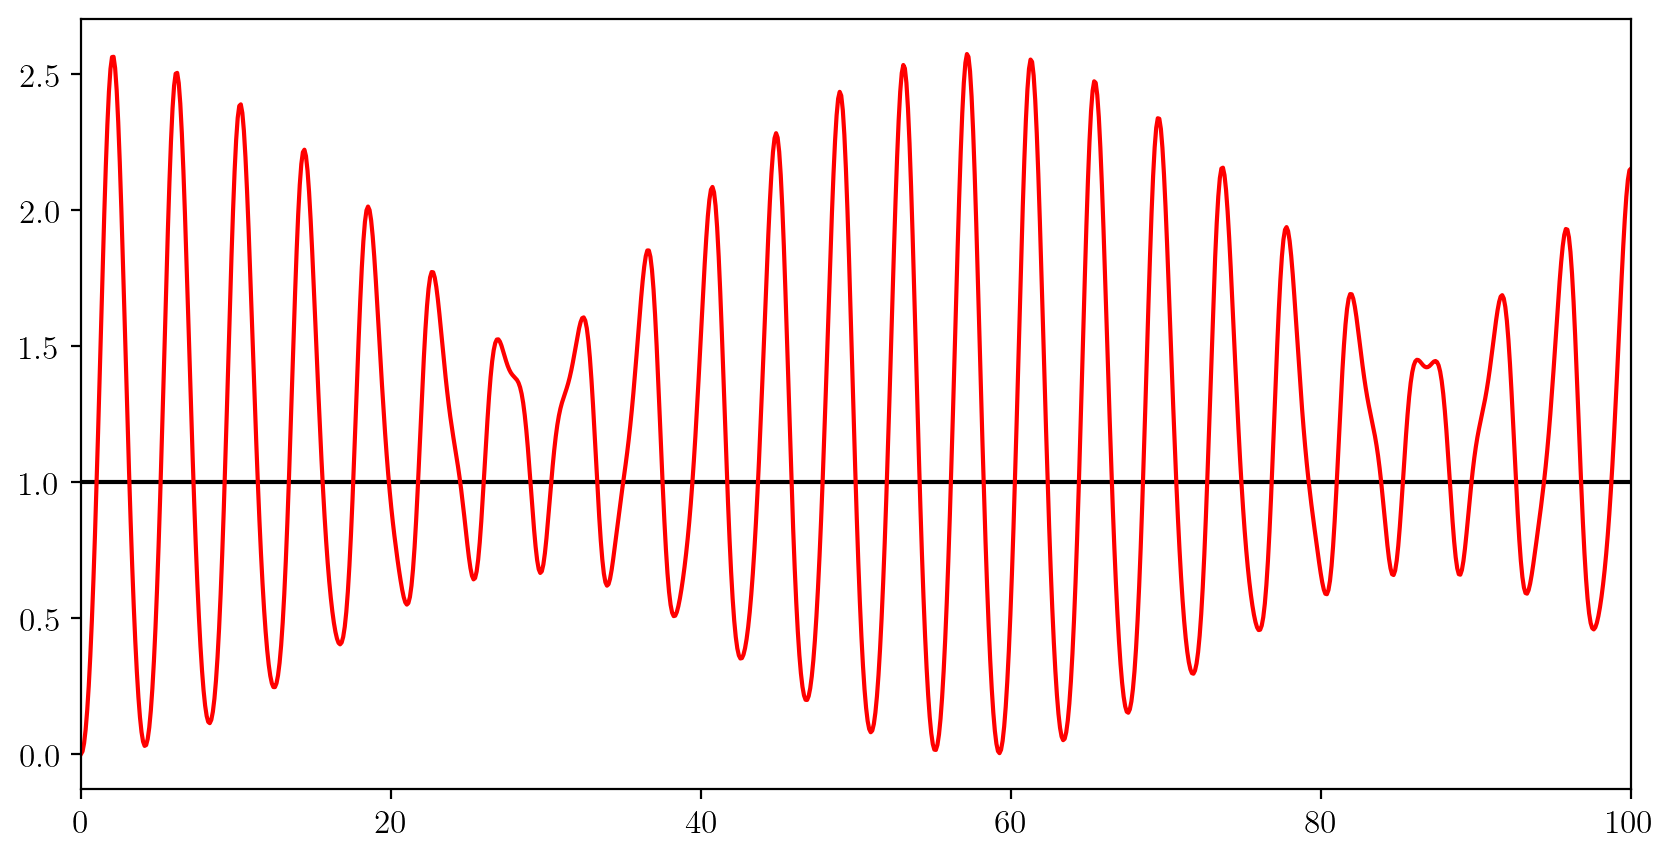

In [151]:
plt.figure(figsize=(10,5), dpi=200)


plt.plot(t_arr, np.array(num_fermion_list), color = 'k')
plt.plot(t_arr, np.array(num_boson_list), color = 'r')
plt.xlim(0, 100)

In [174]:
num_boson_list[23]

array([2.44179836])

(array([ 23,  26,  49,  68,  75, 500, 925, 932, 951, 974, 977]), {})


(0.0, 0.06)

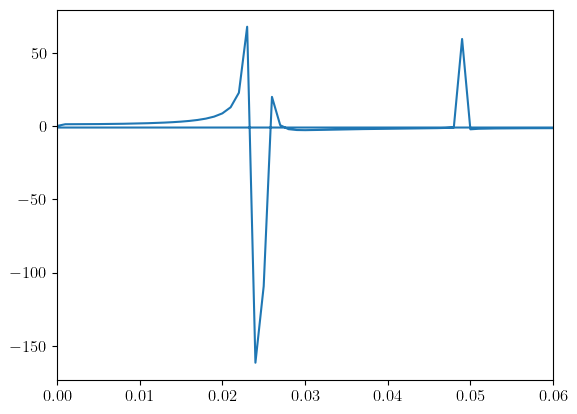

In [172]:
# freq_arr = np.fft.fftfreq(len(t_arr), d=t_arr[1] - t_arr[0])
T = 60
N = len(t_arr)
freq_arr = np.fft.fftfreq(N)
fft_arr = scipy.fft.fft(np.array(num_boson_list).T[0] - np.average(num_boson_list)).real

print(scipy.signal.find_peaks(fft_arr))
plt.plot(freq_arr, fft_arr)
plt.xlim(0, T/N)

# Coherent Boson State

In [121]:
no_fermion_state = np.array([[1, 0]]).T
single_boson_state = Fock([], [], [(0, 1)]).to_qubit_state(max_bosonic_mode=0, max_bosonic_occupancy=Lambda).to_sparse_matrix.toarray()
single_boson_state
statevector = np.kron(no_fermion_state, single_boson_state)

In [125]:
a_dagger_a = ParticleOperator('a0^') + ParticleOperator('a0')
a_dagger_a_matrix = generate_matrix(a_dagger_a, get_fock_basis(a_dagger_a, Lambda))
padded_a_dagger_a_matrix = reduce(np.kron, [np.eye(2), a_dagger_a_matrix])



In [128]:
num_fermion_list = []
num_boson_list = []
coherent_list = []

t_arr = np.linspace(0,100,1000)

for t in t_arr:

    evolved_statevector = evolve_statevector(t, Ef, Eb, g, Lambda, statevector)
    num_fermion = evolved_statevector.T.conjugate() @ padded_number_operator_ferm_matrix @ evolved_statevector
    num_boson = evolved_statevector.T.conjugate() @ padded_number_operator_bose_matrix @ evolved_statevector
    coherent = evolved_statevector.T.conjugate() @ padded_a_dagger_a_matrix @ evolved_statevector
    num_fermion_list.append(num_fermion[0].real)
    num_boson_list.append(num_boson[0].real)
    coherent_list.append(coherent[0].real)

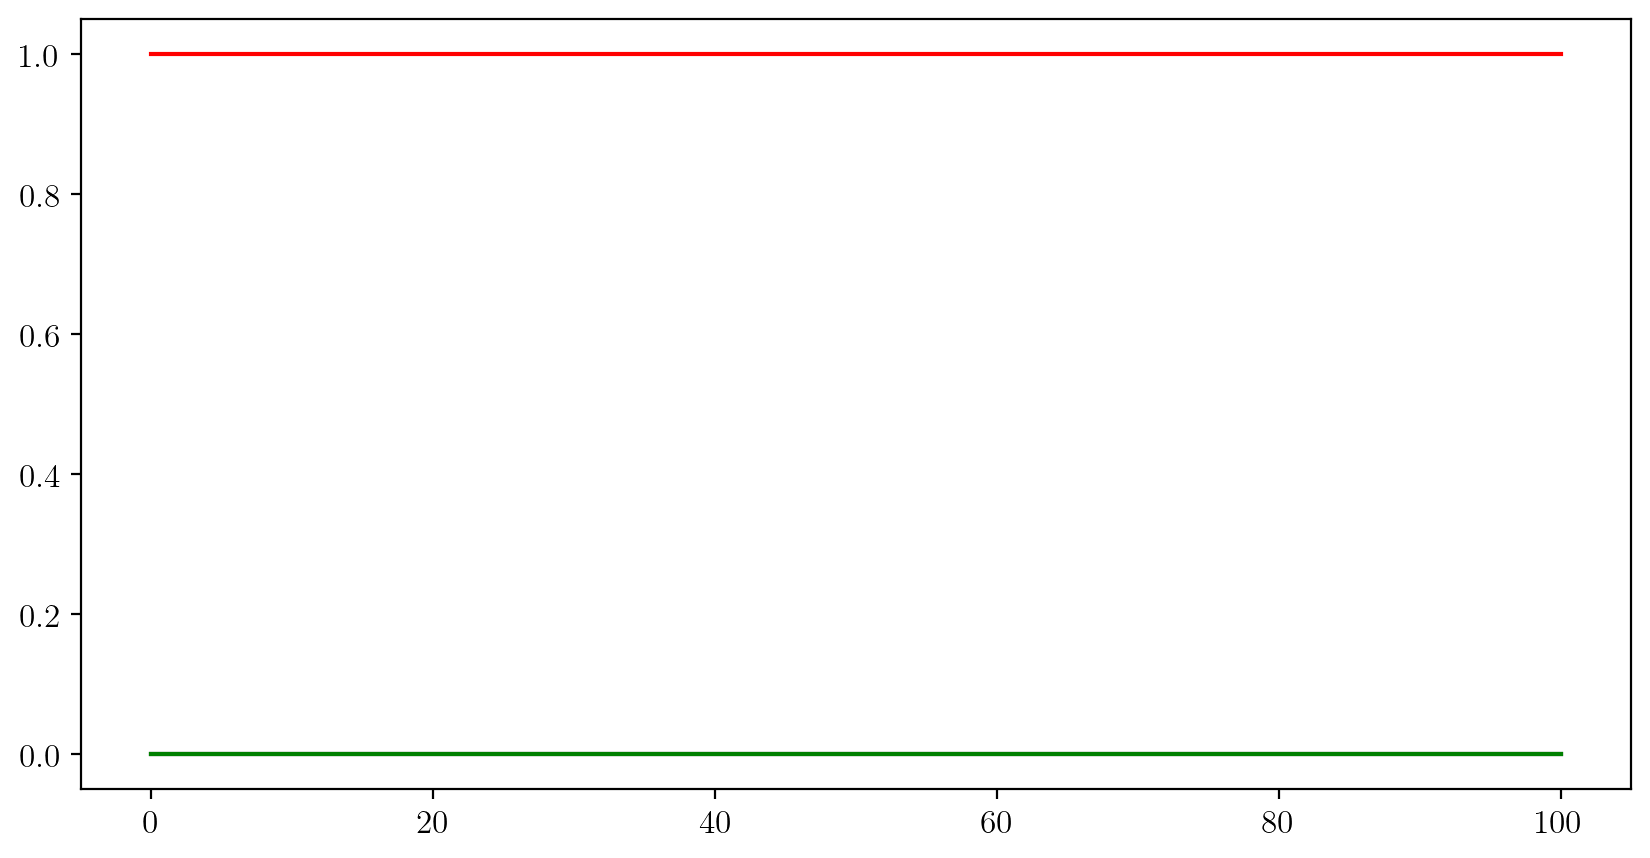

In [129]:
plt.figure(figsize=(10,5), dpi=200)

plt.plot(t_arr, np.array(num_fermion_list), color = 'k')
plt.plot(t_arr, np.array(num_boson_list), color = 'r')
plt.plot(t_arr, np.array(coherent_list), color = 'g')

# 1 Fermion + 1 Boson

In [130]:
single_fermion_state = np.array([[0, 1]]).T
single_boson_state = Fock([], [], [(0, 1)]).to_qubit_state(max_bosonic_mode=0, max_bosonic_occupancy=Lambda).to_sparse_matrix.toarray()
single_boson_state
statevector = np.kron(single_fermion_state, single_boson_state)

In [131]:
num_fermion_list = []
num_boson_list = []
coherent_list = []

t_arr = np.linspace(0,100,1000)

for t in t_arr:

    evolved_statevector = evolve_statevector(t, Ef, Eb, g, Lambda, statevector)
    num_fermion = evolved_statevector.T.conjugate() @ padded_number_operator_ferm_matrix @ evolved_statevector
    num_boson = evolved_statevector.T.conjugate() @ padded_number_operator_bose_matrix @ evolved_statevector
    coherent = evolved_statevector.T.conjugate() @ padded_a_dagger_a_matrix @ evolved_statevector
    num_fermion_list.append(num_fermion[0].real)
    num_boson_list.append(num_boson[0].real)
    coherent_list.append(coherent[0].real)

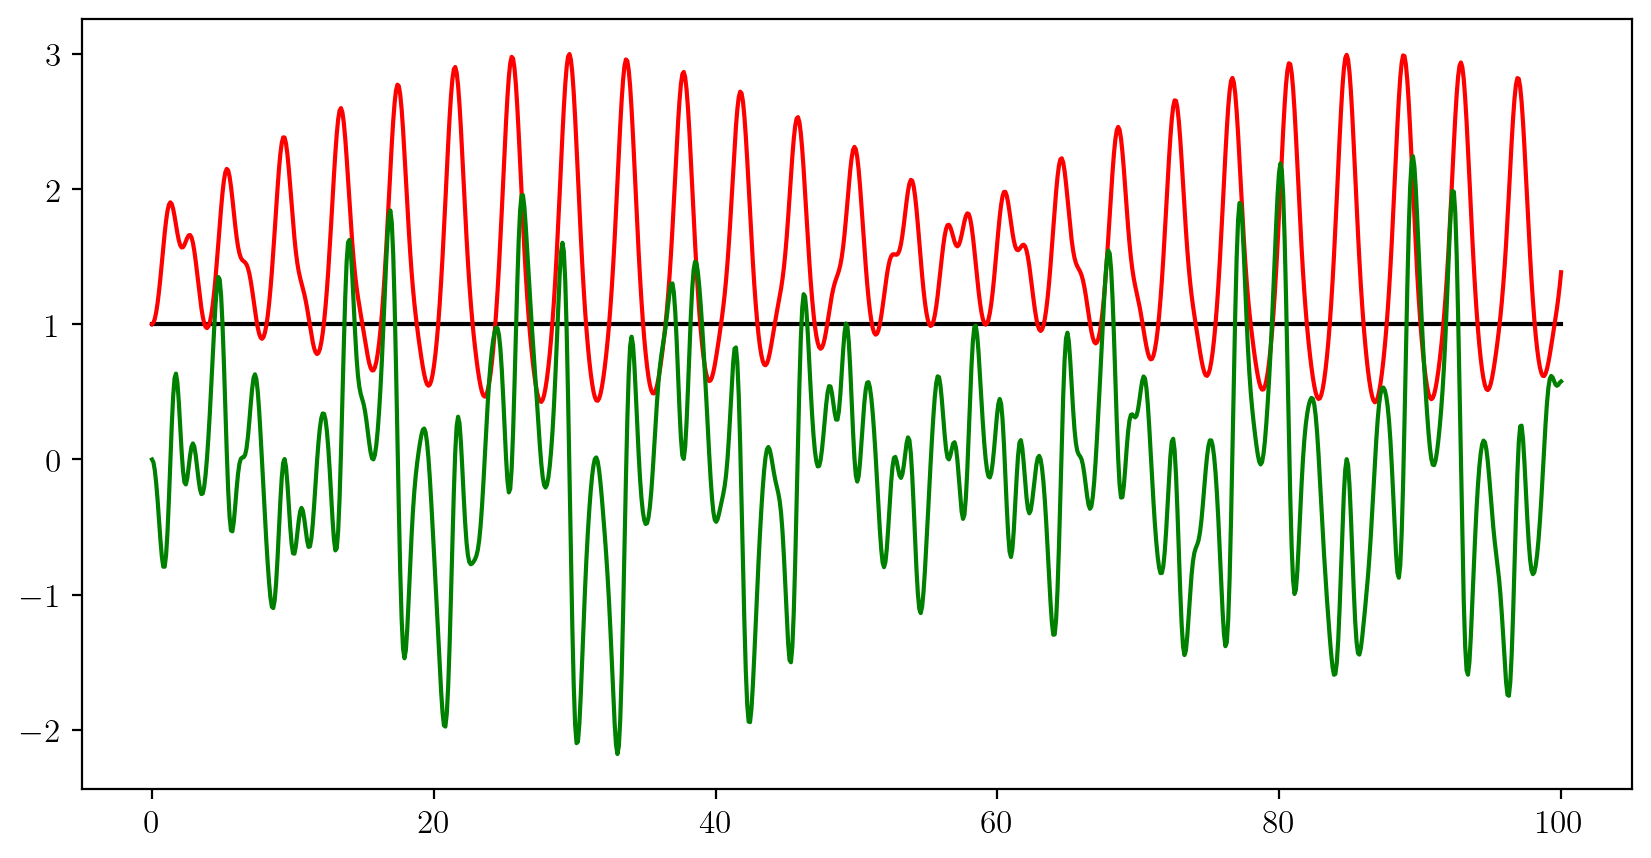

In [132]:
plt.figure(figsize=(10,5), dpi=200)

plt.plot(t_arr, np.array(num_fermion_list), color = 'k')
plt.plot(t_arr, np.array(num_boson_list), color = 'r')
plt.plot(t_arr, np.array(coherent_list), color = 'g')

In [133]:
superposition_fermion_state = np.array([[1, 1]]).T
no_boson_state = Fock([], [], []).to_qubit_state(max_bosonic_mode=0, max_bosonic_occupancy=Lambda).to_sparse_matrix.toarray()
statevector = np.kron(superposition_fermion_state, no_boson_state)

In [134]:
num_fermion_list = []
num_boson_list = []
coherent_list = []

t_arr = np.linspace(0,100,1000)

for t in t_arr:

    evolved_statevector = evolve_statevector(t, Ef, Eb, g, Lambda, statevector)
    num_fermion = evolved_statevector.T.conjugate() @ padded_number_operator_ferm_matrix @ evolved_statevector
    num_boson = evolved_statevector.T.conjugate() @ padded_number_operator_bose_matrix @ evolved_statevector
    coherent = evolved_statevector.T.conjugate() @ padded_a_dagger_a_matrix @ evolved_statevector
    num_fermion_list.append(num_fermion[0].real)
    num_boson_list.append(num_boson[0].real)
    coherent_list.append(coherent[0].real)

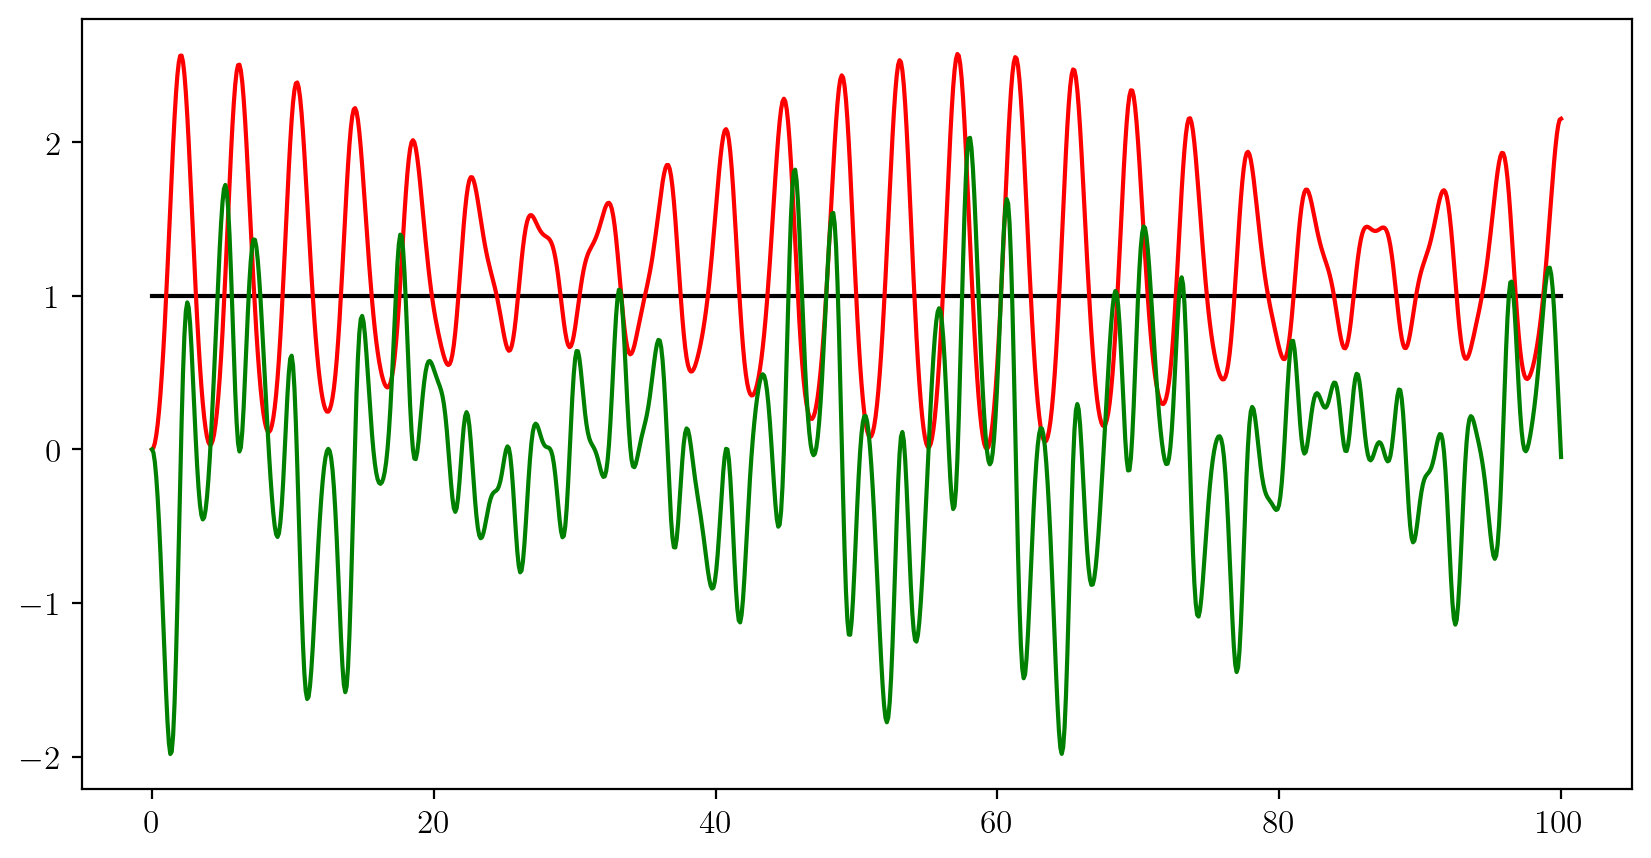

In [135]:
plt.figure(figsize=(10,5), dpi=200)

plt.plot(t_arr, np.array(num_fermion_list), color = 'k')
plt.plot(t_arr, np.array(num_boson_list), color = 'r')
plt.plot(t_arr, np.array(coherent_list), color = 'g')